# Evaluating language knowledge of ELL students from grades 8-12

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [38]:
import re
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import nltk

from textblob import TextBlob
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import precision_recall_curve

from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


## Loading The Dataset

*Using Pandas Library, we’ll load the CSV file. Named it with ellTrainData for the dataset.*

In [3]:
ellTrainData = pd.read_csv('input/train.csv')

In [4]:
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


## Data Profiling & Cleaning

*Get the number of columns and rows*

In [5]:
ellTrainData.shape

(3911, 8)

In [6]:
ellTrainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


*From the info, we know that there are 3911 entries and 8 columns.*

In [7]:
ellTrainData.isnull().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

*There are no null entries.*

In [8]:
ellTrainData.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [9]:
# Basic text cleaning function
def remove_noise(text):
    
    # Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))
    
#     # Remove special characters
#     text = text.apply(lambda x: "".join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
    
#     # Remove punctuation
#     text = text.str.replace('[^\w\s]', '')
    
    # Remove numbers
    text = text.str.replace('\d+', '')
    
#     # Remove Stopwords
#     text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
    
    # Convert to string
    text = text.astype(str)
        
    return text

In [10]:
# Applying noise removal function to data
ellTrainData['filtered_text'] = remove_noise(ellTrainData['full_text'])
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal if u change the school policy ..."
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...


In [11]:
# Defining a sentiment analyser function
def sentiment_analyser(text):
    return text.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

# Applying function to reviews
ellTrainData['polarity'] = sentiment_analyser(ellTrainData['filtered_text'])
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text,polarity
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...,0.103571
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...,0.084853
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal if u change the school policy ...",0.037857
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...,0.225062
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...,0.200216


## Lexicon Normalisation

In [12]:
# Instantiate the Word tokenizer & Word lemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a word lemmatizer function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# Apply the word lemmatizer function to data
ellTrainData['filtered_text_lemmatize'] = ellTrainData['filtered_text'].apply(lemmatize_text)
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text,polarity,filtered_text_lemmatize
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...,0.103571,"[i, think, that, student, would, benefit, from..."
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...,0.084853,"[when, a, problem, is, a, change, you, have, t..."
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal if u change the school policy ...",0.037857,"[dear,, principal, if, u, change, the, school,..."
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...,0.225062,"[the, best, time, in, life, is, when, you, bec..."
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...,0.200216,"[small, act, of, kindness, can, impact, in, ot..."


## Exploratory Analysis and Visualization

In [13]:
ellTrainData['text_len'] = ellTrainData['full_text'].apply(lambda x: len(x))
ellTrainData['words_num'] = ellTrainData['full_text'].apply(lambda x: len(x.split()))

In [14]:
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text,polarity,filtered_text_lemmatize,text_len,words_num
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...,0.103571,"[i, think, that, student, would, benefit, from...",1387,261
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...,0.084853,"[when, a, problem, is, a, change, you, have, t...",2635,533
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal if u change the school policy ...",0.037857,"[dear,, principal, if, u, change, the, school,...",1663,320
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...,0.225062,"[the, best, time, in, life, is, when, you, bec...",3973,728
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...,0.200216,"[small, act, of, kindness, can, impact, in, ot...",1326,234


<AxesSubplot:xlabel='words_num', ylabel='Density'>

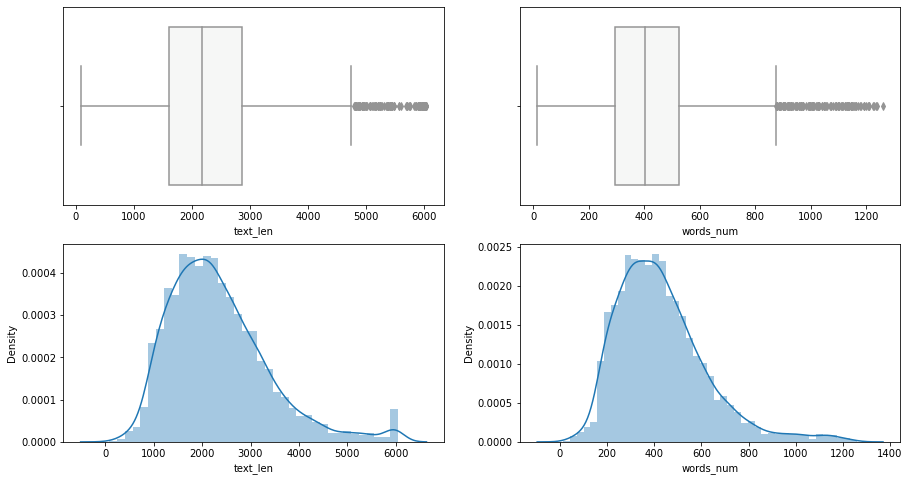

In [15]:
# Length of full_text and words num
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(ellTrainData['text_len'], palette='PRGn', ax = ax[0, 0])
sns.distplot(ellTrainData['text_len'], ax = ax[1, 0])
sns.boxplot(ellTrainData['words_num'], palette='PRGn', ax = ax[0, 1])
sns.distplot(ellTrainData['words_num'], ax = ax[1, 1])

## WordCloud

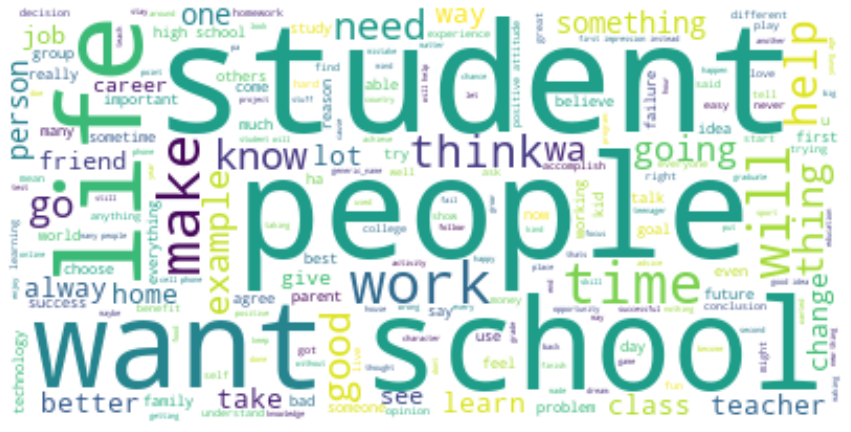

In [16]:
text = " ".join(j for i in ellTrainData['filtered_text_lemmatize'] for j in i)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Getting a text matrix

In [17]:
# Getting a count of words from the documents
cvec = CountVectorizer(min_df=.02, max_df=.7, ngram_range=(1,2), tokenizer=lambda x: x, lowercase=False)
cvec.fit(ellTrainData['filtered_text_lemmatize'])

CountVectorizer(lowercase=False, max_df=0.7, min_df=0.02, ngram_range=(1, 2),
                tokenizer=<function <lambda> at 0x0000021177DBEC10>)

In [18]:
# Getting the total n-gram count
len(cvec.vocabulary_)

3161

In [19]:
# Creating the bag-of-words representation
cvec_counts = cvec.transform(ellTrainData['filtered_text_lemmatize'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (3911, 3161)
nonzero count: 854529
sparsity: 6.91%


In [20]:
# Instantiating the TfidfTransformer
transformer = TfidfTransformer()

# Fitting and transforming n-grams
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<3911x3161 sparse matrix of type '<class 'numpy.float64'>'
	with 854529 stored elements in Compressed Sparse Row format>

In [21]:
# Getting a list of all n-grams
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()

# Putting weighted n-grams into a DataFrame and computing some summary statistics
model = pd.DataFrame(transformed_weights, columns=vocab)
model['Keyword'] = model.idxmax(axis=1)
model['Max'] = model.max(axis=1)
model['Sum'] = model.drop('Max', axis=1).sum(axis=1)
model.head()

,"""",%,",",", and",",and",.,a a,a an,a bad,a better,...,your time,your work,yourself,yourself and,yourself in,"yourself,",yourself.,Keyword,Max,Sum
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,cause,0.225702,11.535185
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,change,0.317050,12.787490
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,sport,0.349862,9.971693
3,0.028633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.168617,0.0,0.100205,0.0,0.082908,afraid,0.238878,15.360263
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,act,0.338237,9.703395


### Merging datasets

In [22]:
# Merging td-idf weight matrix with original DataFrame
model = pd.merge(ellTrainData, model, left_index=True, right_index=True)
model.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text,polarity,...,your time,your work,yourself,yourself and,yourself in,"yourself,",yourself.,Keyword,Max,Sum
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...,0.103571,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,cause,0.225702,11.535185
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...,0.084853,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,change,0.317050,12.787490
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal if u change the school policy ...",0.037857,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,sport,0.349862,9.971693
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...,0.225062,...,0.0,0.0,0.168617,0.0,0.100205,0.0,0.082908,afraid,0.238878,15.360263
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...,0.200216,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,act,0.338237,9.703395


In [23]:
# Getting a view of the top 20 occurring words
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(25)

,Term,Occurrences
2244,student,15642
2872,we,11260
2073,school,11203
2956,will,11142
3140,your,11116
2483,their,10285
1664,my,9159
2896,what,9016
1630,more,8984
949,get,8554


In [24]:
# Getting a view of the top 20 weights
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Weight': weights})
weights_df.sort_values(by='Weight', ascending=False).head(25)

,Term,Weight
2244,student,0.066414
2872,we,0.048284
2073,school,0.044439
3140,your,0.043186
2956,will,0.039460
2483,their,0.037937
1664,my,0.036110
1630,more,0.031753
2896,what,0.031053
3047,would,0.030187


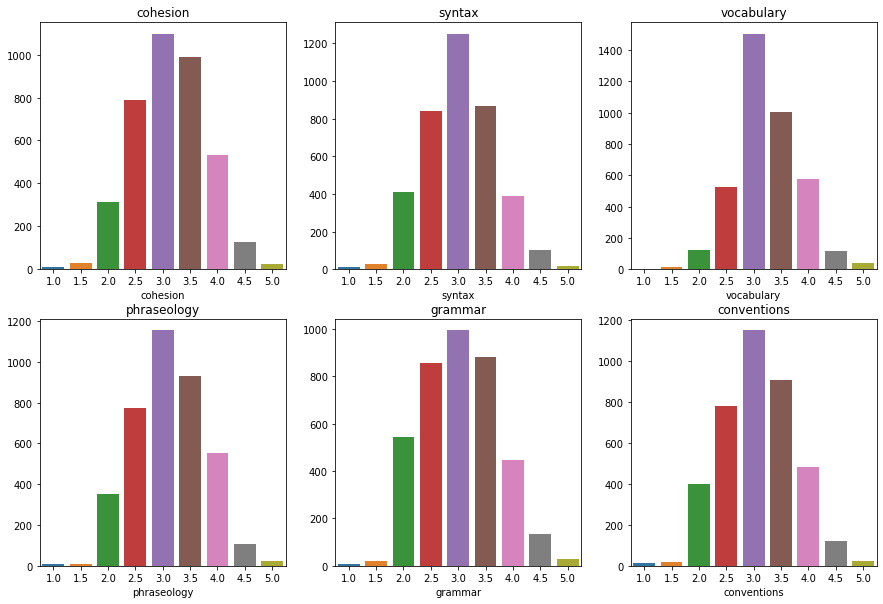

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
1.0,10,11,2,10,8,15
1.5,27,29,14,11,20,20
2.0,315,410,124,350,544,402
2.5,790,839,528,772,855,784
3.0,1096,1250,1503,1153,994,1151
3.5,988,867,1007,929,880,908
4.0,534,388,577,553,447,484
4.5,125,100,115,108,134,122
5.0,26,17,41,25,29,25


In [25]:
# Countplot
scList = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
plt.figure(figsize=(15, 10))
for i, c in enumerate(scList):
    ax = plt.subplot(2, 3, i+1)
    sns.countplot(data = model, x = c)
    ax.set(title = c)
    ax.set(ylabel=None)
plt.show()

# Value counts
model[scList].apply(pd.Series.value_counts)

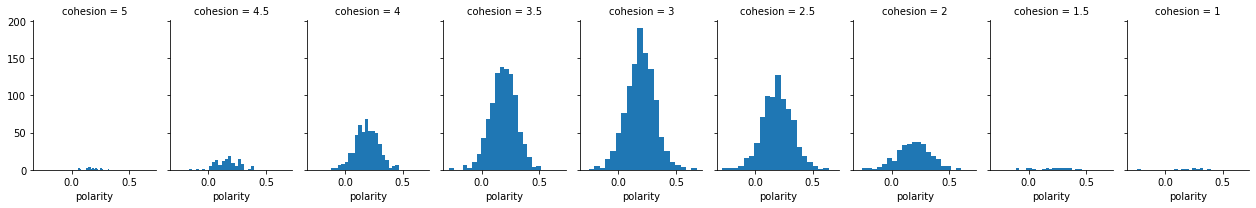

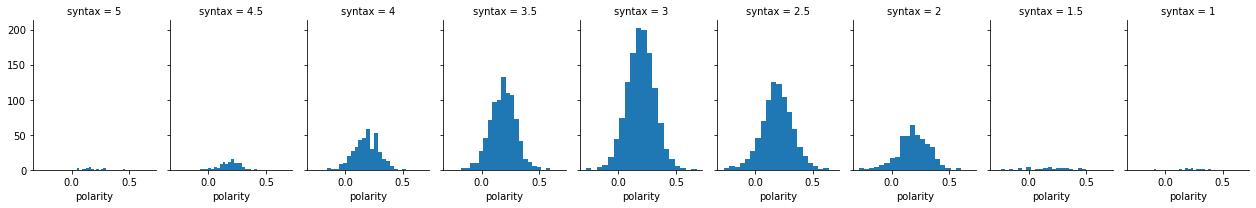

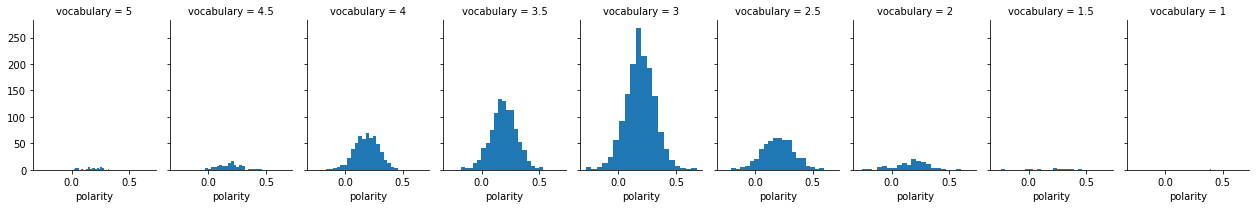

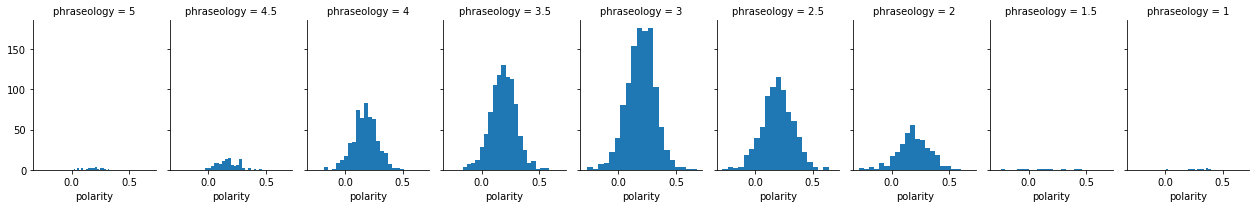

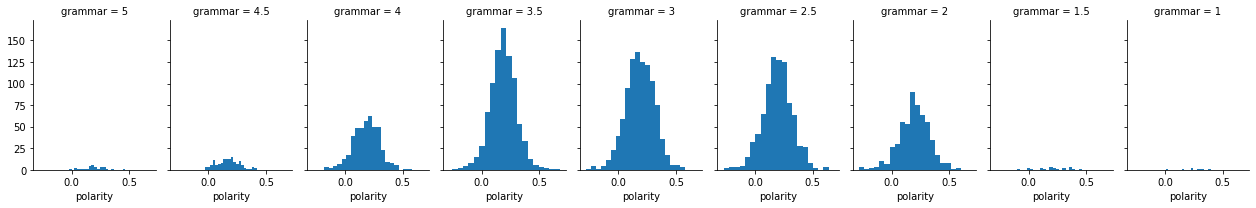

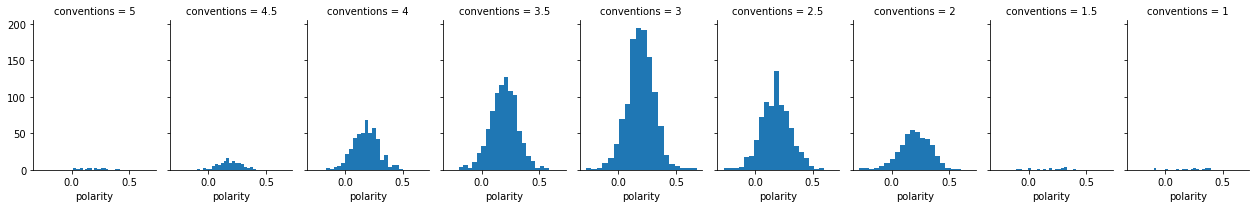

In [26]:
# Visualising polarity between scores
for score in scList:
    g = sns.FacetGrid(model, col=score, col_order=[5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1], aspect=.65)
    g = g.map(plt.hist, "polarity", bins=20)

## Machine Learning

In [27]:
# Defining a function to fit and predict ML algorithms
def modelRes(mod, y_name, x_train, y_train, x_test, y_test):
    mod.fit(x_train, y_train)
    print(y_name)
    acc = cross_val_score(mod, x_train, y_train, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(mod, x_test, y_test, cv = 5)
    print("Accuracy:", round(acc.mean(),3))
    print("Classification Report \n",classification_report(predictions, y_test))

In [28]:
text = remove_noise(ellTrainData['full_text'])

max_words = round(text.apply(lambda x: len(x.split())).max())

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(text)
pad_train = pad_sequences(train_seq, maxlen=max_words, truncating='post')


word_idx_count = len(word_index)
print(word_idx_count)

21912


In [29]:
scList = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

X = pad_train

for score in scList:
    y = ellTrainData[score].replace([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0, 1, 2, 3, 4, 5, 6, 7, 8])
    # Create a train-test split of these variables
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
    model = LogisticRegression()
    modelRes(model, score, X_train, y_train, X_test, y_test)
    

cohesion
Accuracy: 0.209
Classification Report 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         4
         2.0       0.09      0.13      0.10        54
         3.0       0.21      0.20      0.20       199
         4.0       0.28      0.27      0.27       282
         5.0       0.31      0.28      0.30       293
         6.0       0.18      0.18      0.18       131
         7.0       0.04      0.07      0.05        14
         8.0       0.00      0.00      0.00         0

    accuracy                           0.23       978
   macro avg       0.12      0.12      0.12       978
weighted avg       0.24      0.23      0.24       978

syntax
Accuracy: 0.211
Classification Report 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00         0
         2.0       0.13      0.15   

## Prediction

In [30]:
ellTestData = pd.read_csv('input/test.csv')

In [31]:
ellTestData.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [32]:
ellTestData['filtered_text'] = remove_noise(ellTestData['full_text'])
ellTestData.head()

,text_id,full_text,filtered_text
0,0000C359D63E,when a person has no experience on a job their...,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...,do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...","thomas jefferson once states that ""it is wonde..."


In [33]:
test_seq = tokenizer.texts_to_sequences(ellTestData['filtered_text'])
pad_test = pad_sequences(test_seq, maxlen=max_words, truncating='post')

In [34]:
scList = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

submission = pd.DataFrame()

submission['text_id'] = ellTestData['text_id'].copy()

for score in scList:
    y = ellTrainData[score].replace([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0, 1, 2, 3, 4, 5, 6, 7, 8])
    model = LogisticRegression()
    model.fit(pad_train, y)
    print(score, model.score(pad_train, y))
    submission[score] = model.predict(pad_test).tolist()

cohesion 0.6238813602659167
syntax 0.6208130912810023
vocabulary 0.6614676553311174
phraseology 0.619023267706469
grammar 0.6044489900281258
conventions 0.6082843262592688


In [35]:
submission[scList] = submission[scList].replace([0, 1, 2, 3, 4, 5, 6, 7, 8], [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

In [36]:
submission.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,4.0,3.0,4.0,2.0,3.5,2.0
1,000BAD50D026,2.0,2.5,3.0,2.5,2.0,2.0
2,00367BB2546B,2.5,3.0,3.0,2.5,3.5,3.5


## Submission

In [37]:
submission.to_csv("submission.csv", index=False)